In [1]:
%load_ext autoreload
%autoreload 2

In [95]:
from dataclasses import dataclass

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx

from potentiel_solaire.constants import DEFAULT_CRS, CRS_FOR_BUFFERS
from potentiel_solaire.sources.bd_topo import extract_bd_topo, get_topo_zones_of_interest, \
    get_topo_buildings_of_interest
from potentiel_solaire.sources.extract import extract_sources
from potentiel_solaire.sources.schools_establishments import get_schools_establishments_of_interest
from potentiel_solaire.attach_buildings_to_schools import attach_buildings_to_schools

In [3]:
code_departement = "093"

In [174]:
sources = extract_sources()
    
bd_topo_path = extract_bd_topo(code_departement=code_departement)

schools_establishments = get_schools_establishments_of_interest(
    schools_filepath=sources["etablissements"].filepath,
    code_departement=code_departement,
    types_etablissements=['Ecole', 'Lycée', 'Collège'],
    statut_public_prive="Public",
    etat="OUVERT",
    crs=DEFAULT_CRS
)
nb_schools = schools_establishments.shape[0]

communes = gpd.read_file(bd_topo_path, layer="commune").to_crs(DEFAULT_CRS)
geom_of_interest = communes.sjoin(schools_establishments).dissolve()[["geometry"]]

educational_zones = get_topo_zones_of_interest(
    bd_topo_path=bd_topo_path,
    geom_of_interest=geom_of_interest,
    categories=["Science et enseignement"],
    natures=['Collège', 'Lycée', 'Enseignement primaire'],
    crs=DEFAULT_CRS
)
nb_educational_zones = educational_zones.shape[0]

buildings = get_topo_buildings_of_interest(
    bd_topo_path=bd_topo_path,
    geom_of_interest=geom_of_interest,
    crs=DEFAULT_CRS
)
nb_buildings = buildings.shape[0]

2025-03-18 15:38:45,674 - INFO - root - D:\datafrogood\13_potentiel_solaire\algorithme\potentiel_solaire\sources\extract.py - extract_sources - source etablissements already extracted at D:\datafrogood\13_potentiel_solaire\algorithme\data\fr-en-annuaire-education.geojson
2025-03-18 15:38:45,694 - INFO - root - D:\datafrogood\13_potentiel_solaire\algorithme\potentiel_solaire\sources\bd_topo.py - extract_bd_topo - gpkg file D:\datafrogood\13_potentiel_solaire\algorithme\data\BDTOPO_3-4_TOUSTHEMES_GPKG_LAMB93_D093_2024-12-15\BDTOPO\1_DONNEES_LIVRAISON_2024-12-00134\BDT_3-4_GPKG_LAMB93_D093-ED2024-12-15\BDT_3-4_GPKG_LAMB93_D093-ED2024-12-15.gpkg for departement 093 already extracted
d:\datafrogood\13_potentiel_solaire\algorithme\.venv\Lib\site-packages\pyogrio\core.py:279: RuntimeWarning: Field format 'character varying' not supported
  return ogr_read_info(
d:\datafrogood\13_potentiel_solaire\algorithme\.venv\Lib\site-packages\pyogrio\core.py:279: RuntimeWarning: Field format 'character v

In [5]:
schools_buildings = attach_buildings_to_schools(
    schools_establishments=schools_establishments,
    educational_zones=educational_zones,
    buildings=buildings
)

d:\datafrogood\13_potentiel_solaire\algorithme\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
@dataclass
class ItemsOfInterest:
    educational_zones: list[str]
    buildings: list[str]
    schools: list[str]

    
def get_facecolor_nb_rattachements(value):
    if value == 0:
        return "yellow"
    elif value == 1:
        return "green"
    else:
        return "red"


def plot_zone_of_interest(
    zone_of_interest: gpd.GeoDataFrame,
    edu_zones: gpd.GeoDataFrame = educational_zones,
    topo_buildings: gpd.GeoDataFrame = buildings,
    schools: gpd.GeoDataFrame = schools_establishments,
    schools_buildings_attached: gpd.GeoDataFrame = schools_buildings,
    buffer_size: int = 5,
):  
    fig, ax = plt.subplots(figsize=(20, 10))
    
    buildings_in_zone = gpd.sjoin(
        topo_buildings, zone_of_interest[["geometry"]], how='inner', predicate='intersects'
    )
    
    buildings_attach_count = schools_buildings_attached.groupby(
        by="cleabs_bat", as_index=False
    ).identifiant_de_l_etablissement.count().rename(
        columns={"identifiant_de_l_etablissement": "nb_rattachements"}
    )
    buildings_in_zone = buildings_in_zone.merge(
        buildings_attach_count,
        left_on="cleabs",
        right_on="cleabs_bat",
        how="left",
    ).copy()
    buildings_in_zone["nb_rattachements"] = buildings_in_zone["nb_rattachements"].fillna(0)
    buildings_in_zone["facecolor"] = buildings_in_zone["nb_rattachements"].apply(get_facecolor_nb_rattachements)
    
    buildings_in_zone.plot(
        ax=ax, edgecolor="black", linewidth=0.5, facecolor=buildings_in_zone["facecolor"], alpha=0.5
    )
    
    educational_zones_in_zone = gpd.sjoin(
        edu_zones, zone_of_interest[["geometry"]], how='inner', predicate='intersects'
    )
    educational_zones_in_zone.plot(
        ax=ax, color="none", edgecolor='blue', linewidth=2
    )
    
    zone_buffered = zone_of_interest[["geometry"]].copy().to_crs(CRS_FOR_BUFFERS)
    zone_buffered.geometry = zone_buffered.geometry.buffer(buffer_size)
    zone_buffered = zone_buffered.to_crs(DEFAULT_CRS)
    
    schools_in_zone = gpd.sjoin(
        schools, zone_buffered, how='inner', predicate='intersects'
    )
    schools_in_zone.plot(
        ax=ax, color="blue", alpha=1
    )
    
    cx.add_basemap(ax, crs=DEFAULT_CRS, zoom=19, alpha=0.5)
    
    plt.show()
    
    print(f"Duplicated buildings in zone_of_interest: {buildings_in_zone[buildings_in_zone['nb_rattachements'] > 1][['cleabs_bat', 'nb_rattachements']]}")
    
    return ItemsOfInterest(
        educational_zones=list(educational_zones_in_zone["cleabs"].unique()), 
        buildings=list(buildings_in_zone["cleabs"].unique()),
        schools=list(schools_in_zone["identifiant_de_l_etablissement"].unique()),
    )

### 1. Overlap entre plusieurs zones d education

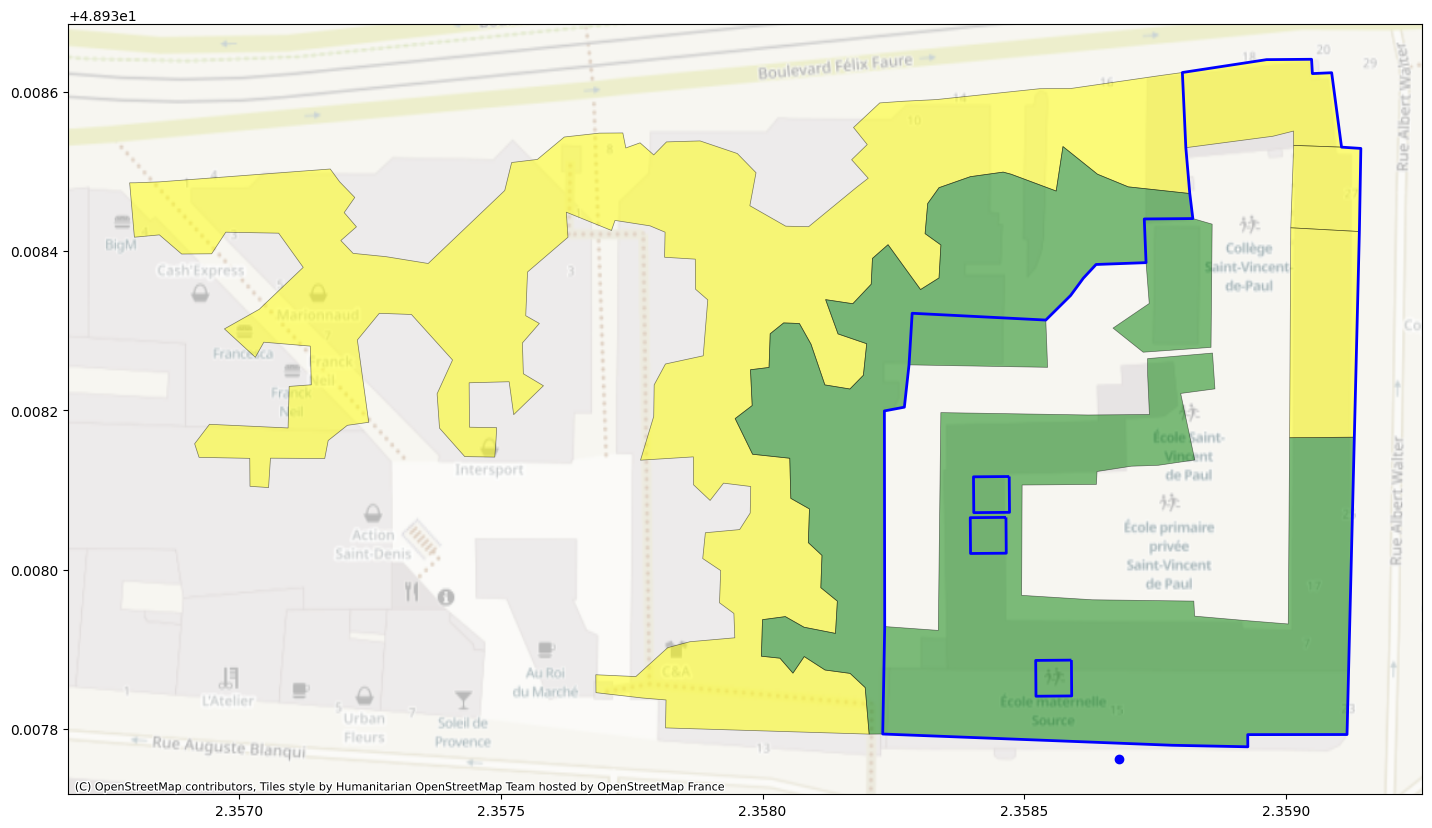

Duplicated buildings in zone_of_interest: Empty DataFrame
Columns: [cleabs_bat, nb_rattachements]
Index: []


In [ ]:
zone_of_interest_1 = educational_zones[educational_zones["cleabs"].isin(["SURFACTI0000000002555603"])].dissolve()
items_1 = plot_zone_of_interest(
    zone_of_interest=zone_of_interest_1
)

L'idée est de : <br> *  Regrouper les polygones qui se touchent et de récupérer un dataframe avec géométries + index (df_union) <br> * Rajouter au dataframe des zones d'éducations l'index de la grande zone dans laquelle il se trouve (zones_with_id_union)

In [165]:
import shapely

def unionize_educationnal_zone(
    educational_zones : gpd.GeoDataFrame = educational_zones
) -> gpd.GeoDataFrame:
    ''' Créée un gdf avec les zones unies'''
    
    #Uni les polygones en fonction de leur géométrie
    polygons_unionized = shapely.ops.unary_union(educational_zones['geometry'].to_list())
    #Créer un gdf avec index + géomtrie
    df_union = gpd.GeoDataFrame({'geometry' : [polygons_unionized]}, 
                            crs="EPSG:4326").explode().reset_index(drop=True)
    return df_union

def link_bw_zones(
    educational_zones : gpd.GeoDataFrame = educational_zones,
    unionized_zone : gpd.GeoDataFrame = unionize_educationnal_zone(educational_zones)
) -> gpd.GeoDataFrame:
    ''' Ajoute l'ID de la grande zone a chaque zone d'éducation'''
    
    zones_with_id_union = gpd.sjoin(educational_zones, unionized_zone[['geometry']],
                                    how='inner', predicate='intersects').rename(columns = {"index_right" : "id_gde_zone"})
    return zones_with_id_union
    

In [177]:
df_union = unionize_educationnal_zone()
new_educational_zones = link_bw_zones(educational_zones)

In [181]:
df_union.iloc[5]

geometry    POLYGON ((2.34682 48.9046, 2.3468 48.90461, 2....
Name: 5, dtype: geometry

### 2. Batiment overlap plusieurs zones d'educations

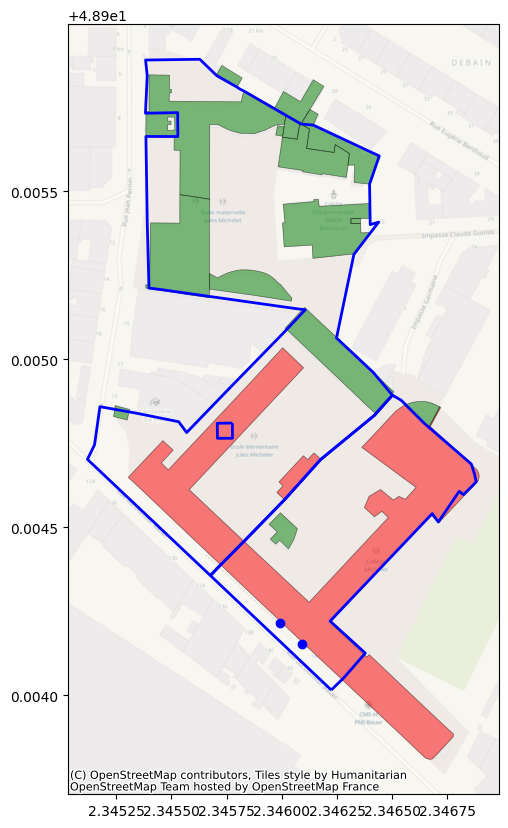

Duplicated buildings in zone_of_interest:                   cleabs_bat  nb_rattachements
11  BATIMENT0000000246488966                 3
13  BATIMENT0000000246489005                 2


In [166]:
zone_of_interest_2 = educational_zones[educational_zones["cleabs"].isin(["SURFACTI0000000002555878", "SURFACTI0000000002555879", "SURFACTI0000000244244919"])].dissolve()
items_2 = plot_zone_of_interest(zone_of_interest=zone_of_interest_2)

In [ ]:

# new_educational_zones
educational_zones[educational_zones["cleabs"].isin(["SURFACTI0000000002555878", "SURFACTI0000000002555879", "SURFACTI0000000244244919"])]

,cleabs,categorie,nature,toponyme,identifiants_sources,geometry,id_gde_zone
3511,SURFACTI0000000002555878,Science et enseignement,Collège,Collège Michelet,MEN:0931144N,"MULTIPOLYGON (((2.34622 48.90402, 2.34628 48.9...",5
3512,SURFACTI0000000002555879,Science et enseignement,Enseignement primaire,École Maternelle Jules Michelet,MEN:0930475L,"MULTIPOLYGON (((2.34568 48.90436, 2.34572 48.9...",5
3515,SURFACTI0000000244244919,Science et enseignement,Enseignement primaire,École Élémentaire Michelet,MEN:0930297T,"MULTIPOLYGON (((2.34578 48.90481, 2.34571 48.9...",5


### 3. Batiment overlap à peine la zone d'education

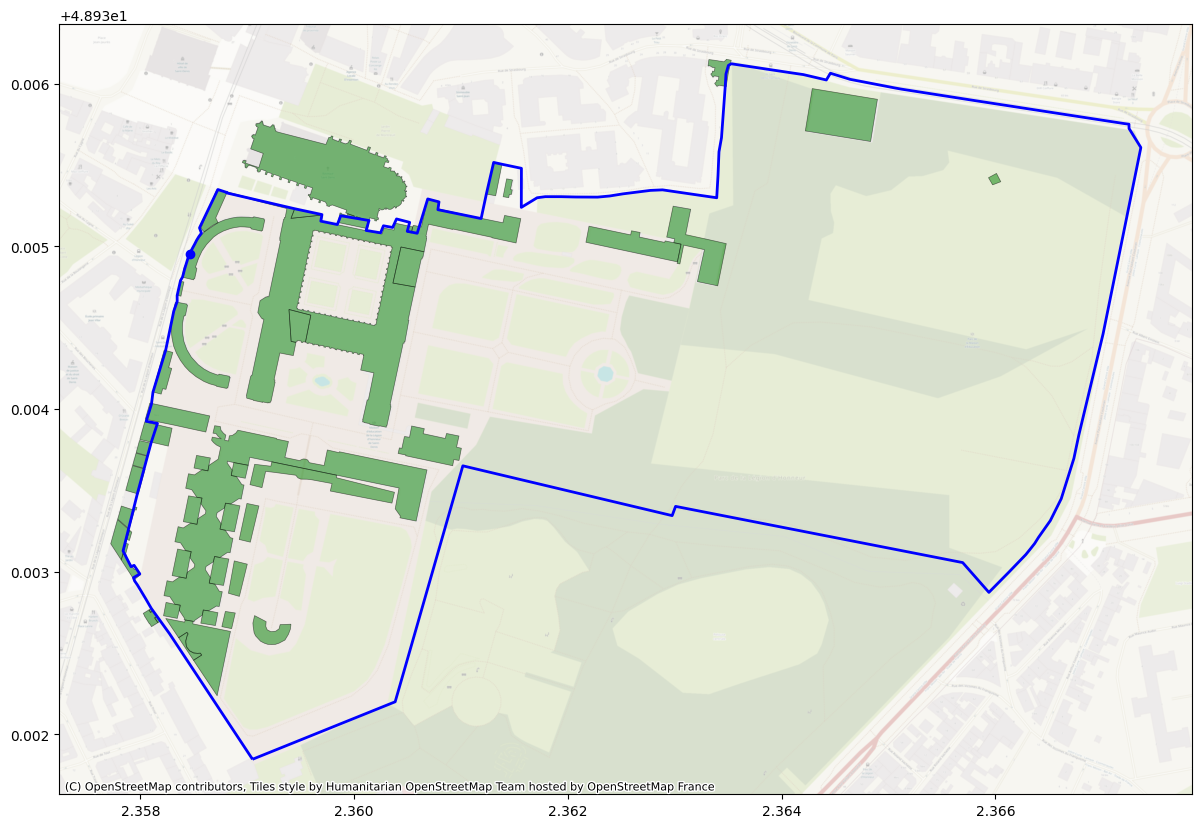

Duplicated buildings in zone_of_interest: Empty DataFrame
Columns: [cleabs_bat, nb_rattachements]
Index: []


In [171]:
zone_of_interest_3 = educational_zones[educational_zones["cleabs"].isin(["SURFACTI0000000002555651"])].dissolve()
items_3 = plot_zone_of_interest(zone_of_interest=zone_of_interest_3)

### En calculant d'abord l'aire de tous les bâtiments

In [113]:
# Je récupère l'aire totale de mes bâtiments 
buildings['total_area'] = buildings['geometry'].to_crs(2154).apply(lambda x : x .area)

#Selection de ma zone de test 
zone_test = educational_zones[educational_zones["cleabs"].isin(["SURFACTI0000000002555651"])].dissolve()
#Je réalise l'intersection
building_in_zone_part = gpd.overlay(buildings, zone_test, how ='intersection')


filtre = 50
#Je calcule l'aire des batiments présents dans ma zone 
building_in_zone_part['area'] = building_in_zone_part['geometry'].to_crs(2154).apply(lambda x :x.area)

#Je ne récupère que les batîments présent à + de 50% dans la zone
filter_area = building_in_zone_part.loc[((building_in_zone_part['area']/building_in_zone_part['total_area'])*100)>filtre]
#Maintenant je recupère la géomtrie entière des batiments présents 
building_in_zone = buildings.loc[buildings['cleabs'].isin(filter_area['cleabs_1'].to_list())]
print(f"Filtre à : {filtre} %\nNb de batiments avant filtre : {len(building_in_zone_part)}")
print(f"Après filtre : {len(building_in_zone)}")

Filtre à : 50 %
Nb de batiments avant filtre : 49
Après filtre : 37


In [105]:
def filter_buldings_on_area(
    buildings : gpd.GeoDataFrame,
    educational_zones : gpd.GeoDataFrame
) -> gpd.GeoDataFrame :
    
    # Calcul de l'aire totale des bâtiments 
    buildings['total_area'] = buildings['geometry'].to_crs(2154).apply(lambda x : x .area)
    #Intersection bâtiments/zone
    building_in_zone = gpd.overlay(buildings, educational_zones, how ='intersection')
    #Calcul de l'aire des bâtiments présent dans la zone
    building_in_zone['area'] = building_in_zone['geometry'].to_crs(2154).apply(lambda x :x.area)
    #Filtre pour ne récupérer que les bâtiments présents à plus de 50%
    filter_area = building_in_zone.loc[((building_in_zone['area']/building_in_zone['total_area'])*100)> 50]
    #Récupération finale des bâtiments 
    building_in_zone = buildings.loc[buildings['cleabs'].isin(filter_area['cleabs_1'].to_list())]
    return building_in_zone



In [106]:
len(filter_buldings_on_area(buildings, zone_test ))

37

### 4. Etablissements au meme endroit et overlap des zones d'éducation associees

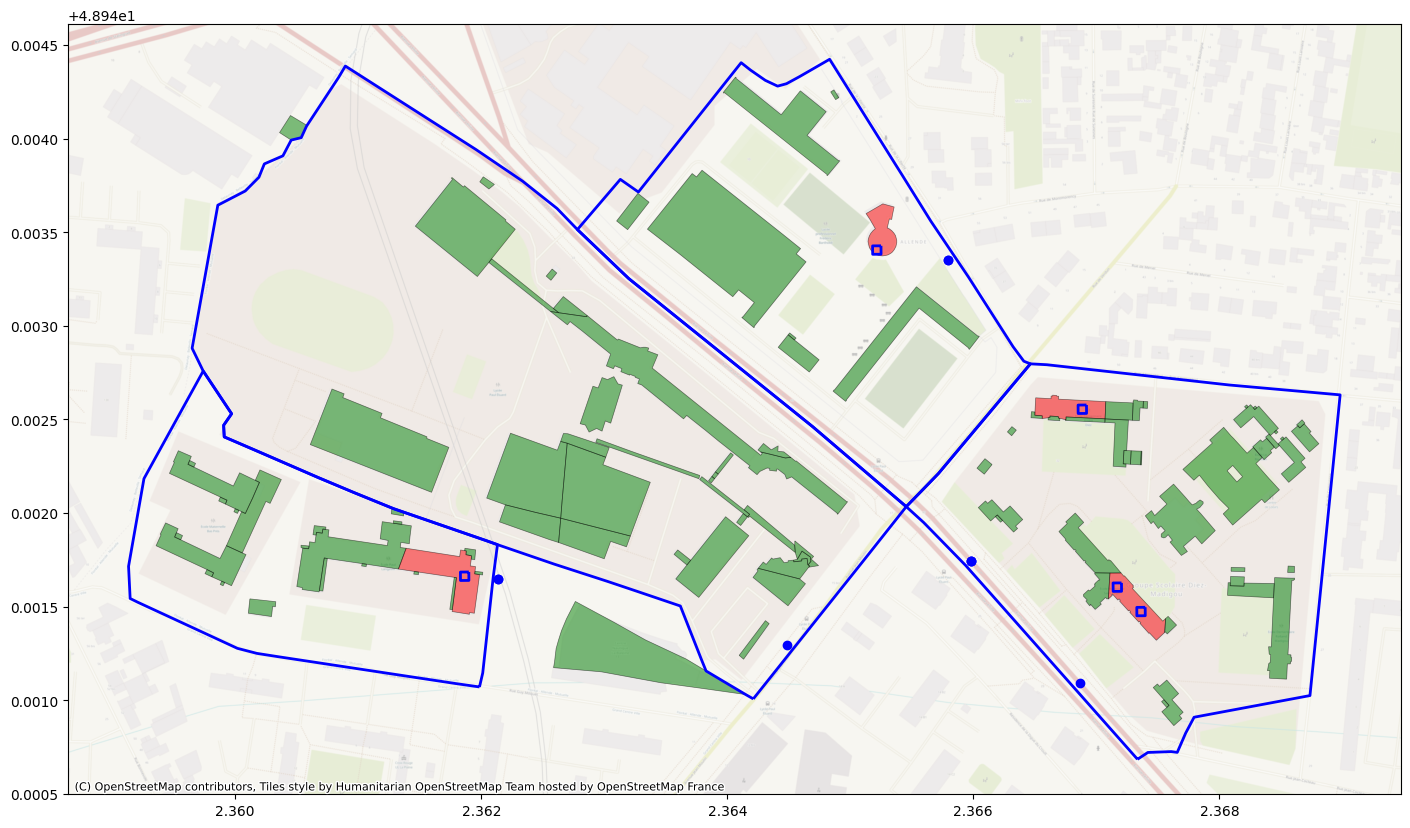

Duplicated buildings in zone_of_interest:                   cleabs_bat  nb_rattachements
12  BATIMENT0000000243407841                 2
40  BATIMENT0000000243407804                 3
74  BATIMENT0000000243407510                 2
88  BATIMENT0000000243407963                 2


In [10]:
zone_of_interest_4 = educational_zones[educational_zones["cleabs"].isin(["SURFACTI0000000002555609", "SURFACTI0000002215707916", "SURFACTI0000000002555601", "SURFACTI0000000002555600", "SURFACTI0000000002555602"])].dissolve()
items_4 = plot_zone_of_interest(zone_of_interest=zone_of_interest_4)

### 5. Cas d echec le plus frequent de la premiere methode de rattachement

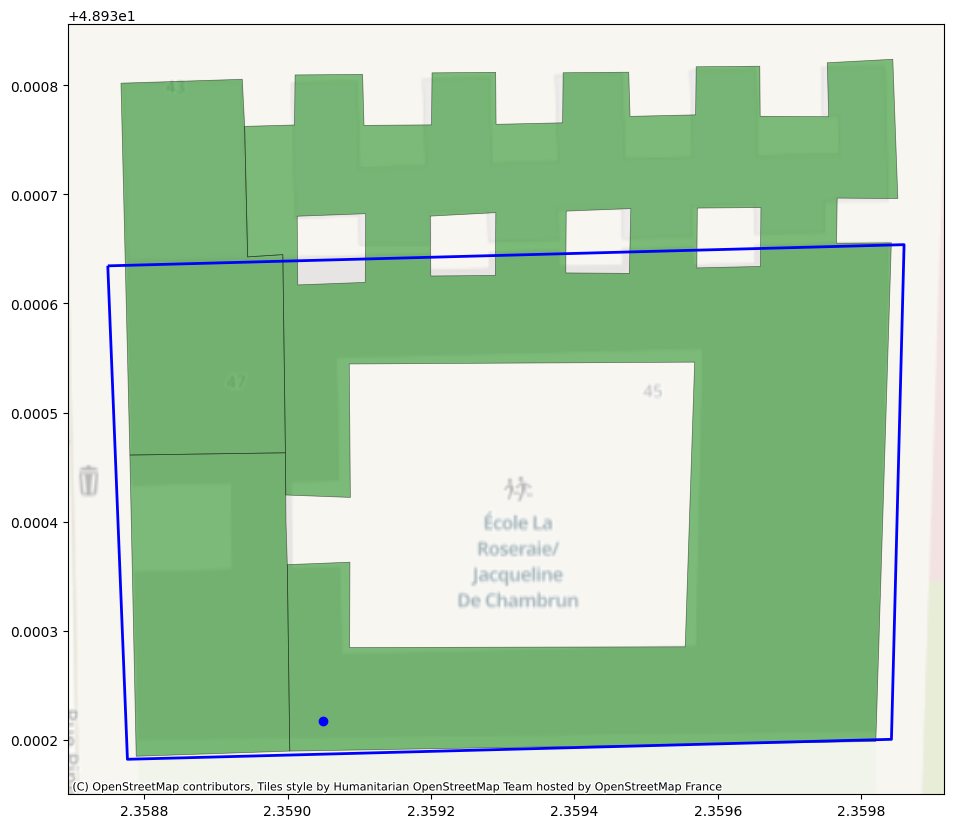

Duplicated buildings in zone_of_interest: Empty DataFrame
Columns: [cleabs_bat, nb_rattachements]
Index: []


In [11]:
zone_of_interest_5 = educational_zones[educational_zones["cleabs"].isin(["SURFACTI0000000351259092"])].dissolve()
items_5 = plot_zone_of_interest(zone_of_interest=zone_of_interest_5)

Avec la méthode des aires, on peut récupérer les batiments en entier. La question se pose pour le filtre 

In [102]:
# On reprend la bae du calcul réalisé plus haut 

# Je récupère l'aire totale de mes bâtiments 
buildings['total_area'] = buildings['geometry'].to_crs(2154).apply(lambda x : x .area)

#Selection de ma zone de test 
zone_test = educational_zones[educational_zones["cleabs"].isin(["SURFACTI0000000351259092"])]
#Je réalise l'intersection
building_in_zone = gpd.overlay(buildings, zone_test, how ='intersection')


filtre = 50
#Je calcule l'aire des batiments présents dans ma zone 
building_in_zone['area'] = building_in_zone['geometry'].to_crs(2154).apply(lambda x :x.area)

#Je ne récupère que les batîments présent à + de 50% dans la zone
filter_area = building_in_zone.loc[((building_in_zone['area']/building_in_zone['total_area'])*100)>filtre]
#Maintenant je recupère la géomtrie entière des batiments présents 
building_in_zone = buildings.loc[buildings['cleabs'].isin(filter_area['cleabs_1'].to_list())]
print(f"Filtre à : {filtre} %\nNb de batiments avant filtre : {len(building_in_zone)}")
print(f"Après filtre : {len(filter_area)}")


Filtre à : 50 %
Nb de batiments avant filtre : 3
Après filtre : 3


In [ ]:

def filter_buldings_on_area(
    buildings : gpd.GeoDataFrame,
    educational_zones : gpd.GeoDataFrame
) -> gpd.GeoDataFrame :
    
    # Calcul de l'aire totale des bâtiments 
    buildings['total_area'] = buildings['geometry'].to_crs(2154).apply(lambda x : x .area)
    #Intersection bâtiments/zone
    building_in_zone = gpd.overlay(buildings, educational_zones, how ='intersection')
    #Calcul de l'aire des bâtiments présent dans la zone
    building_in_zone['area'] = building_in_zone['geometry'].to_crs(2154).apply(lambda x :x.area)
    #Filtre pour ne récupérer que les bâtiments présents à plus de 50%
    filter_area = building_in_zone.loc[((building_in_zone['area']/building_in_zone['total_area'])*100)> 50]
    #Récupération finale des bâtiments 
    building_in_zone = buildings.loc[buildings['cleabs'].isin(filter_area['cleabs_1'].to_list())]
    return building_in_zone



C:\Users\thiba\AppData\Local\Temp\ipykernel_10236\723862029.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  filter_buldings_on_area(buildings, zone_test).to_file("select.shp")
d:\datafrogood\13_potentiel_solaire\algorithme\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'construction_legere' to 'constructi'
  ogr_write(
2025-03-18 11:37:03,238 - INFO - pyogrio._io - d:\datafrogood\13_potentiel_solaire\algorithme\.venv\Lib\site-packages\pyogrio\raw.py - write - Created 3 records


# Test final 

In [184]:
import shapely

def unionize_educationnal_zone(
    educational_zones : gpd.GeoDataFrame = educational_zones
) -> gpd.GeoDataFrame:
    ''' Créée un gdf avec les zones unies'''
    
    #Uni les polygones en fonction de leur géométrie
    polygons_unionized = shapely.ops.unary_union(educational_zones['geometry'].to_list())
    #Créer un gdf avec index + géomtrie
    df_union = gpd.GeoDataFrame({'geometry' : [polygons_unionized]}, 
                            crs="EPSG:4326").explode().reset_index(drop=True)
    return df_union

def link_bw_zones(
    educational_zones : gpd.GeoDataFrame = educational_zones,
    unionized_zone : gpd.GeoDataFrame = unionize_educationnal_zone(educational_zones)
) -> gpd.GeoDataFrame:
    ''' Ajoute l'ID de la grande zone a chaque zone d'éducation'''
    
    zones_with_id_union = gpd.sjoin(educational_zones, unionized_zone[['geometry']],
                                    how='inner', predicate='intersects').rename(columns = {"index_right" : "id_gde_zone"})
    return zones_with_id_union


def filter_buldings_on_area(
    buildings : gpd.GeoDataFrame = buildings,
    educational_zones : gpd.GeoDataFrame = link_bw_zones()
) -> gpd.GeoDataFrame :
    
    # Calcul de l'aire totale des bâtiments 
    buildings['total_area'] = buildings['geometry'].to_crs(2154).apply(lambda x : x .area)
    #Intersection bâtiments/zone
    building_in_zone = gpd.overlay(buildings, educational_zones, how ='intersection')
    #Calcul de l'aire des bâtiments présent dans la zone
    building_in_zone['area'] = building_in_zone['geometry'].to_crs(2154).apply(lambda x :x.area)
    #Filtre pour ne récupérer que les bâtiments présents à plus de 50%
    filter_area = building_in_zone.loc[((building_in_zone['area']/building_in_zone['total_area'])*100)> 50]
    #Récupération finale des bâtiments 
    building_in_zone = buildings.loc[buildings['cleabs'].isin(filter_area['cleabs_1'].to_list())]
    return building_in_zone



In [ ]:
# Pour le work flow

# J'unifie tous mes polygones 
df_union = unionize_educationnal_zone()

#Je rajoute l'ID des grands polygones aux petits 
zones_with_id = link_bw_zones()

#Je filtre les batiments qui sont pas a 50% dans une grande zone 
buildings_in_zone = filter_buldings_on_area()
buildings_in_zone.to_file("buildings.shp")

C:\Users\thiba\AppData\Local\Temp\ipykernel_10236\666620358.py:34: UserWarning: `keep_geom_type=True` in overlay resulted in 444 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  building_in_zone = gpd.overlay(buildings, educational_zones, how ='intersection')
C:\Users\thiba\AppData\Local\Temp\ipykernel_10236\3400750763.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  buildings_in_zone.to_file("buildings.shp")
d:\datafrogood\13_potentiel_solaire\algorithme\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'construction_legere' to 'constructi'
  ogr_write(
2025-03-18 15:48:38,723 - INFO - pyogrio._io - d:\datafrogood\13_potentiel_solaire\algorithme\.venv\Lib\site-packages\pyogrio\raw.py - write - Created 4,605 records
